<h1>Explainability tools</h1>
<p>
This notebook is related to explainability posts from my blog: <p>
<a>https://orikatzdatascience.wordpress.com/2020/08/27/shap/ </a>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
from eli5 import show_prediction
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence, partial_dependence
import lime 
import lime.lime_tabular

In [3]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['PRICE'] = boston.target
X = boston_df.drop('PRICE', axis = 1)
y = boston_df['PRICE']
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


<h2>SHAP Example</h2>
Using the SHAP package
<h3>Linear Regression</h3>


In [5]:
linear_reg = LinearRegression()
linear_reg.fit(X, y)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_reg.coef_})
coefficients = coefficients.append({'Feature':'Intercept', 'Coefficient':linear_reg.intercept_}, ignore_index=True)
coefficients

,Feature,Coefficient
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


In [7]:
coefficients['Values_2'] = np.append(X.iloc[[2]].to_numpy()[0],[1])
coefficients['coef*values_2'] = coefficients['Values_2'] * coefficients['Coefficient']
coefficients['Mean'] = np.append(X.mean(axis=0).to_numpy(),[1])
coefficients['coef*mean'] = coefficients['Mean'] * coefficients['Coefficient']
prediction = {'Feature':'Prediction', 'Coefficient':np.nan, 'Values_2':np.nan, 'coef*values_2': coefficients['coef*values_2'].sum(), 'Mean': np.nan, 
              'coef*mean': coefficients['coef*mean'].sum()}
coefficients = coefficients.append(prediction, ignore_index=True)
coefficients['Difference = Shapley vals'] = coefficients['coef*values_2'] - coefficients['coef*mean']
coefficients

,Feature,Coefficient,Values_2,coef*values_2,Mean,coef*mean,Difference = Shapley vals
0,CRIM,-0.108011,0.02729,-0.002948,3.613524,-0.390302,0.387354
1,ZN,0.046420,0.00000,0.000000,11.363636,0.527505,-0.527505
2,INDUS,0.020559,7.07000,0.145349,11.136779,0.228957,-0.083607
3,CHAS,2.686734,0.00000,0.000000,0.069170,0.185841,-0.185841
4,NOX,-17.766611,0.46900,-8.332541,0.554695,-9.855051,1.522511
5,RM,3.809865,7.18500,27.373882,6.284634,23.943610,3.430272
6,AGE,0.000692,61.10000,0.042295,68.574901,0.047469,-0.005174
7,DIS,-1.475567,4.96710,-7.329288,3.795043,-5.599839,-1.729449
8,RAD,0.306049,2.00000,0.612099,9.549407,2.922591,-2.310492
9,TAX,-0.012335,242.00000,-2.984972,408.237154,-5.035440,2.050468


In [8]:
explainer = shap.LinearExplainer(linear_reg, X)
shap_values = explainer.shap_values(X)
shap_values[2]

array([ 0.38735396, -0.52750521, -0.08360738, -0.18584127,  1.5225108 ,
        3.43027162, -0.00517431, -1.72944891, -2.31049211,  2.05046779,
        0.62455782,  0.33667293,  4.52502468])

<h3>Random Forest Analysis</h3>

In [10]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X, y)
print("Random forest score: {:.5f}".format(forest.score(X, y)))

Random forest score: 0.97393


In [11]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X)
shap_values

array([[ 3.34486872e-01,  5.71501615e-02,  6.98189624e-02, ...,
         3.71001559e-01,  4.47129808e-03,  4.24261472e+00],
       [ 1.48361665e-01, -3.59513510e-02, -1.06419938e-01, ...,
         1.41703665e-01,  1.18940534e-01,  1.74028909e+00],
       [ 1.32402177e-01,  3.17097342e-01, -3.87540436e-01, ...,
        -1.33830223e-01,  1.50778355e-01,  4.64968221e+00],
       ...,
       [ 1.95695908e-01, -3.76687869e-03, -1.09087523e-01, ...,
        -8.60674470e-01, -5.69047145e-02,  8.64041281e-01],
       [ 4.22422728e-01, -6.36203172e-03, -1.41063605e-01, ...,
        -7.65454641e-01, -3.04103528e-02,  2.64847720e+00],
       [ 1.14605843e-01,  5.19652367e-03, -1.10775896e-01, ...,
        -6.00768330e-01,  3.49711719e-02, -6.95734265e-01]])

<h3>Local Explanation</h3>
Explaining a specific instanse

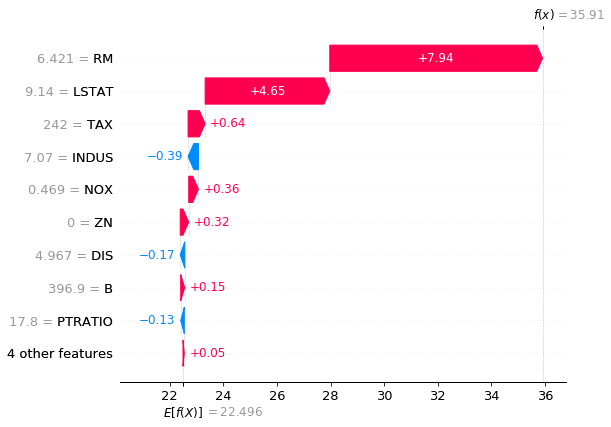

In [13]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[2,:], X.iloc[1,:])

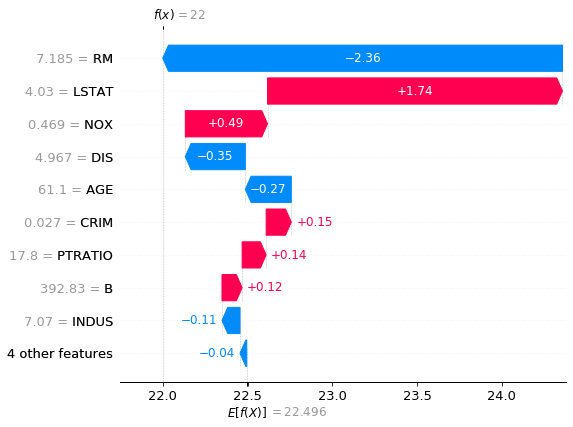

In [14]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[1,:], X.iloc[2,:])

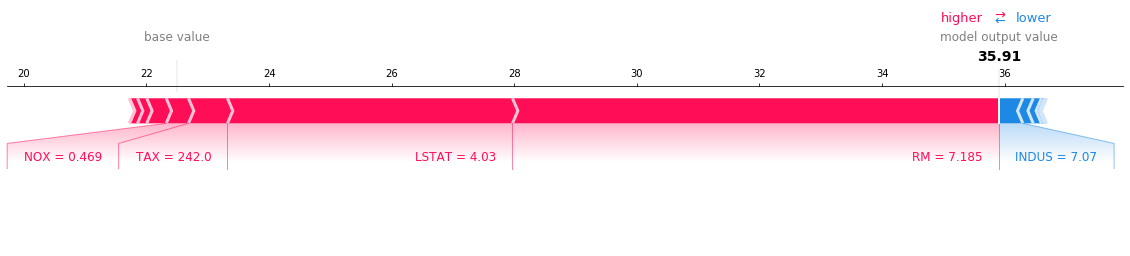

In [15]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X.iloc[2,:], matplotlib=True)

<h3>Global Explenation</h3>
Explaining the model

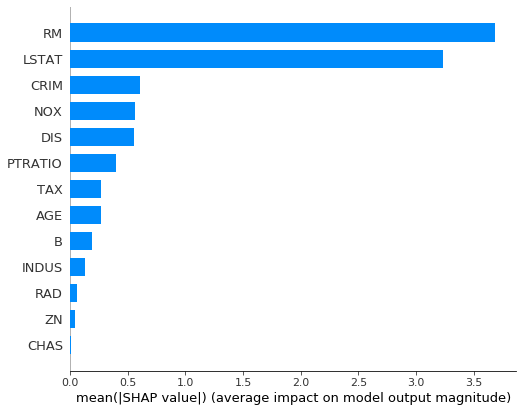

In [16]:
shap.summary_plot(shap_values, X, plot_type="bar")

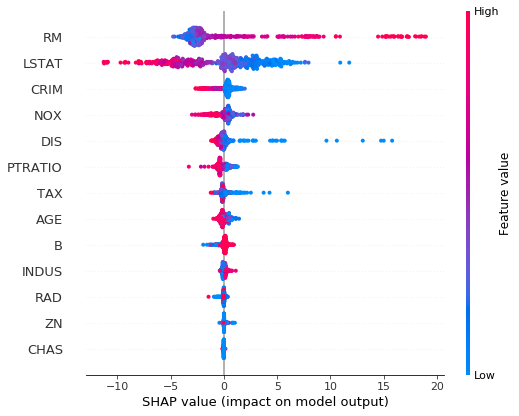

In [17]:
shap.summary_plot(shap_values, X)

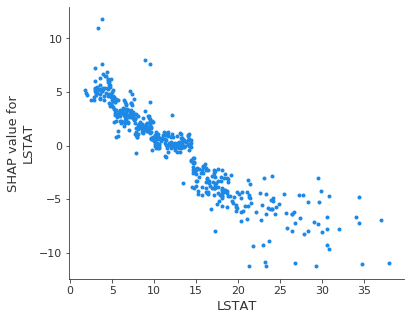

In [18]:
shap.dependence_plot('LSTAT', shap_values, X, interaction_index=None) 

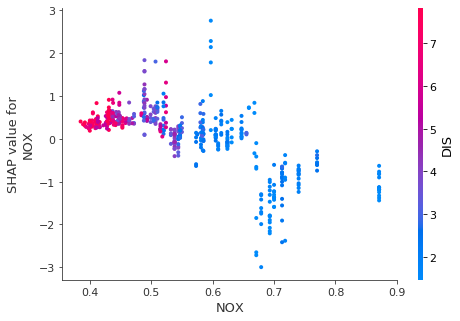

In [19]:
shap.dependence_plot('NOX', shap_values, X, interaction_index='DIS') 

<h2>Other Methods</h2>
<h3>Permutation Feature Importance</h3>
Using the eli5 package, global explanation only

In [57]:
def feature_permutation_plot(X, y, model):
    perm = PermutationImportance(model).fit(X, y)
    perm_df = pd.DataFrame({'Feature Importance': perm.feature_importances_, 'Feature': X.columns})
    perm_df = perm_df.sort_values(by=['Feature Importance'], ascending=False)
    fig, ax = plt.subplots()
    y_pos = np.arange(len(perm_df))
    ax.barh(y_pos, perm_df['Feature Importance'], alpha = 0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(perm_df['Feature'])
    ax.invert_yaxis()  
    ax.set_xlabel('Mean decrease in R^2 when a feature is permuted')
    ax.set_title('Permutation Feature Importance')
    plt.show()

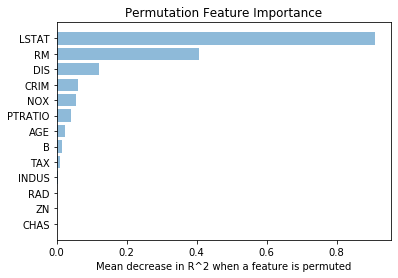

In [58]:
feature_permutation_plot(X, y, forest)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
forest.fit(X_train, y_train)
print("Random forest score - trainig set: {:.5f}".format(forest.score(X_train, y_train)))
print("Random forest score - test set: {:.5f}".format(forest.score(X_test, y_test)))

Random forest score - trainig set: 0.97216
Random forest score - test set: 0.89936


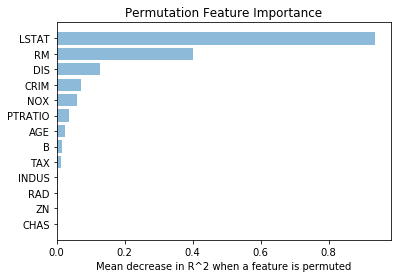

In [60]:
feature_permutation_plot(X_train, y_train, forest)

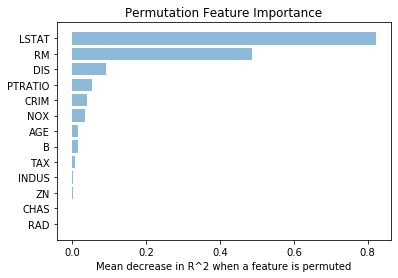

In [61]:
feature_permutation_plot(X_test, y_test, forest)

<h3>LIME</h3>
Local explanation only

In [47]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X), feature_names=X.columns, class_names=['price'], 
                                                   categorical_features=['chas'], verbose=True, mode='regression')

In [54]:
exp = lime_explainer.explain_instance(np.array(X)[0], forest.predict, num_features=3, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 21.459703166992725
Prediction_local [30.49428047]
Right: 25.45


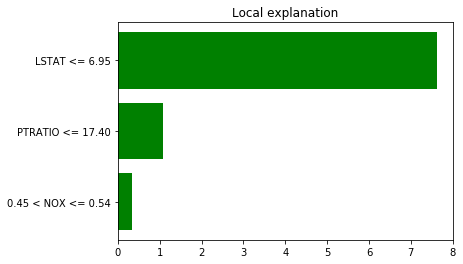

In [55]:
fig = exp.as_pyplot_figure()

Intercept 23.59662792434915
Prediction_local [24.50239042]
Right: 22.259999999999998


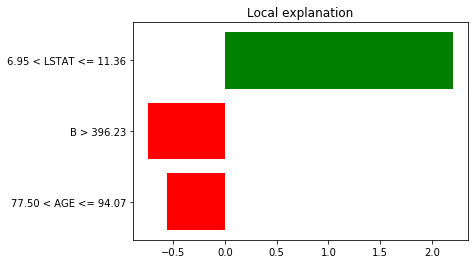

In [56]:
exp = lime_explainer.explain_instance(np.array(X)[1], forest.predict, num_features=3, top_labels=1)
fig = exp.as_pyplot_figure()

<h3>PDP Plots</h3>

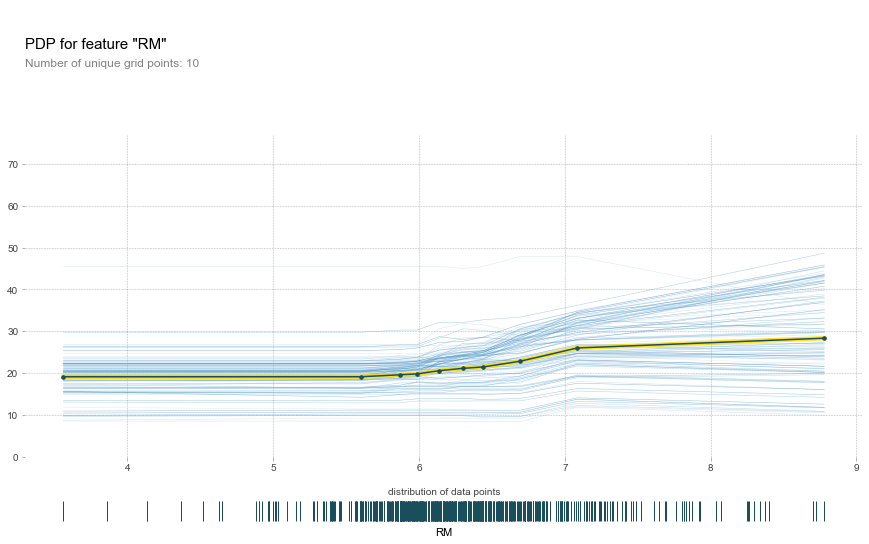

In [73]:
pdp_RM = pdp.pdp_isolate(model=forest, dataset=X, model_features=X.columns, feature='RM')
fig, axes = pdp.pdp_plot(pdp_RM, 'RM', frac_to_plot=0.2, plot_lines=True, plot_pts_dist=True, center = False)

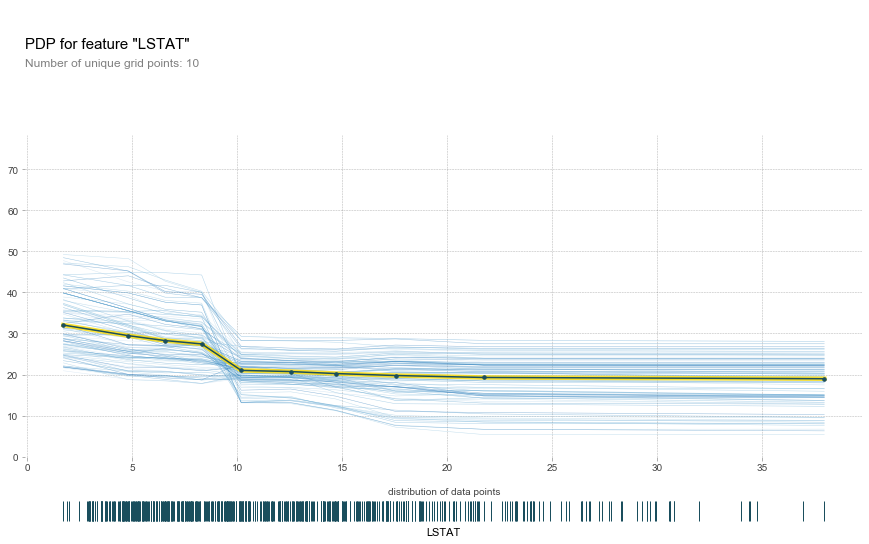

In [68]:
pdp_LSTAT = pdp.pdp_isolate(model=forest, dataset=X, model_features=X.columns, feature='LSTAT')
fig, axes = pdp.pdp_plot(pdp_LSTAT, 'LSTAT', frac_to_plot=0.2, plot_lines=True, plot_pts_dist=True, center = False)

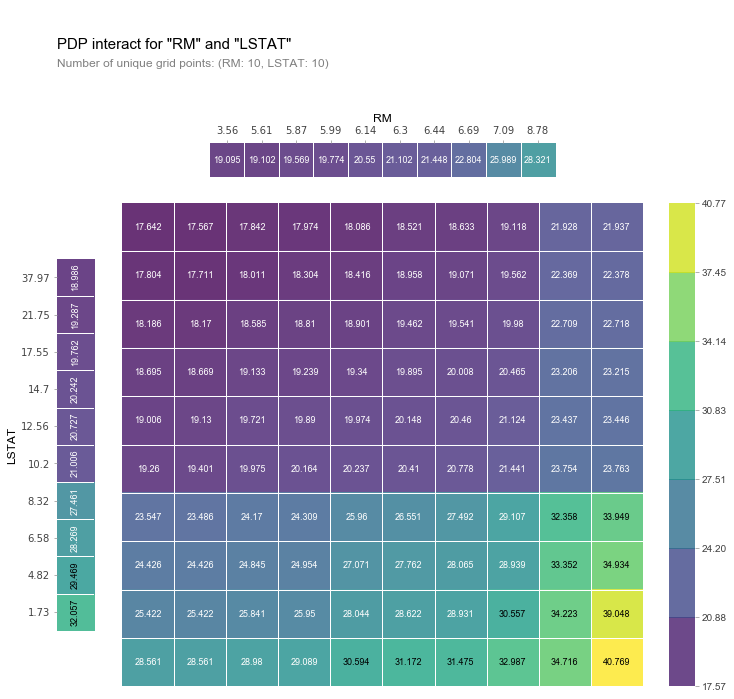

In [74]:
inter1 = pdp.pdp_interact(model=forest, dataset=X, model_features=X.columns, features=['RM', 'LSTAT'])
fig, axes = pdp.pdp_interact_plot(inter1, ['RM', 'LSTAT'], plot_type='grid', x_quantile=True, plot_pdp=True)

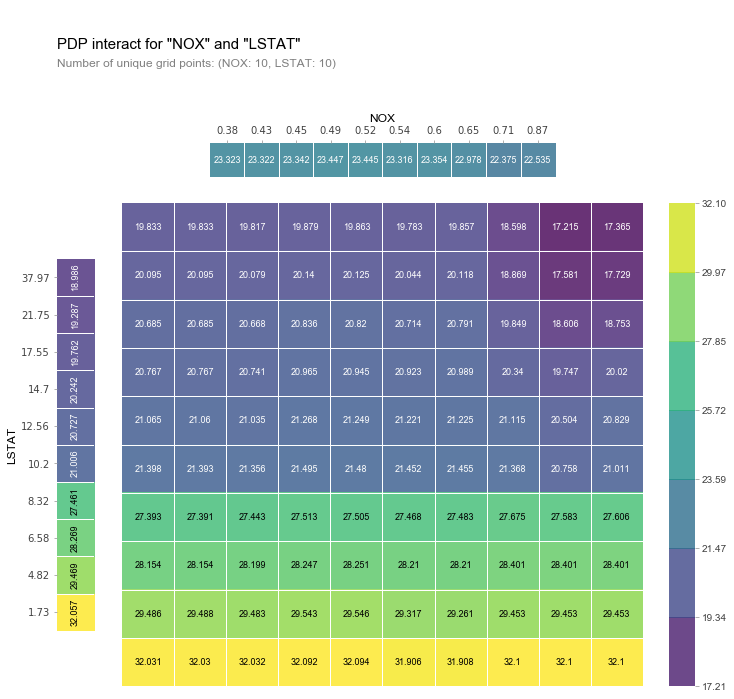

In [71]:
inter2 = pdp.pdp_interact(model=forest, dataset=X, model_features=X.columns, features=['NOX', 'LSTAT'])
fig, axes = pdp.pdp_interact_plot(inter2, ['NOX', 'LSTAT'], plot_type='grid', x_quantile=True, plot_pdp=True)